## Project Name : WeRateDogs Data Analysis

## Investigation Overview

In this project our goal is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

The dataset that you will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## Dataset Overview

In this project, we will work on the following three datasets.

1) Enhanced Twitter Archive : The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. One column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, I have filtered for tweets with ratings only (there are 2356).

2) Additional Data via the Twitter API : Back to the basic-ness of Twitter archives retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least. But we, because we have the WeRateDogs Twitter archive and specifically the tweet IDs within it, can gather this data for all 5000+. And then we are going to query Twitter's API to gather this valuable data.

3) Image Predictions File : It is a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [2]:
# Import the libraries needed for this project

import pandas as pd
import numpy as np
import requests
import os
import tweepy as tw
import json
import re
from IPython.display import HTML

## Gathering the Data

#### 1) Gathering WeRateDogs Twitter Archive Data

In [3]:
# WeRateDogs Twitter archive file obtained as a csv file. Pandas dataframe created from csv file.
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Exploration of data in file
twitter_archive_df.head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None


In [5]:
# Exploration of data types and missing data.
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

#### 2) Gathering Tweet Image Predictions Data

In [7]:
#Using the requests package download image predictions data
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [12]:
#check the contents of the request
response.content

b"tweet_id\tjpg_url\timg_num\tp1\tp1_conf\tp1_dog\tp2\tp2_conf\tp2_dog\tp3\tp3_conf\tp3_dog\n666020888022790149\thttps://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg\t1\tWelsh_springer_spaniel\t0.465074\tTrue\tcollie\t0.156665\tTrue\tShetland_sheepdog\t0.0614285\tTrue\n666029285002620928\thttps://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg\t1\tredbone\t0.506826\tTrue\tminiature_pinscher\t0.07419169999999999\tTrue\tRhodesian_ridgeback\t0.07201\tTrue\n666033412701032449\thttps://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg\t1\tGerman_shepherd\t0.596461\tTrue\tmalinois\t0.13858399999999998\tTrue\tbloodhound\t0.11619700000000001\tTrue\n666044226329800704\thttps://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg\t1\tRhodesian_ridgeback\t0.408143\tTrue\tredbone\t0.360687\tTrue\tminiature_pinscher\t0.222752\tTrue\n666049248165822465\thttps://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg\t1\tminiature_pinscher\t0.560311\tTrue\tRottweiler\t0.243682\tTrue\tDoberman\t0.154629\tTrue\n666050758794694657\thttps://pbs.twimg.com/

In [13]:
#create a folder for image predictions data
folder_name = 'image_predictions'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [14]:
#Write image predictions data to a file in our folder
with open(os.path.join(folder_name, url.split('/')[-1]),mode = 'wb') as file:
    file.write(response.content)

In [15]:
image_predictions_df = pd.read_csv('image-predictions.tsv', sep='\t')

In [16]:
# Exploration of data in file
image_predictions_df.head(3)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True


In [17]:
# Exploration of data types and missing fields.
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### 3) Gathering Additional Twitter API Data 

In [18]:
#Preparing the Tweepy API for gathering each tweet's retweet 
#count and favorite ("like") count at the minimum and any additional data found interesting.

consumer_key = #
consumer_secret = #
access_token = #
access_secret = #

auth = tw.OAuthHandler(consumer_key,consumer_secret)
auth.set_access_token(access_token,access_secret)

api = tw.API(auth,parser=tw.parsers.JSONParser(), wait_on_rate_limit=True)

In [19]:
# Creating list of tweet ids
tweet_id = twitter_archive_df['tweet_id']
list(tweet_id)

[892420643555336193,
 892177421306343426,
 891815181378084864,
 891689557279858688,
 891327558926688256,
 891087950875897856,
 890971913173991426,
 890729181411237888,
 890609185150312448,
 890240255349198849,
 890006608113172480,
 889880896479866881,
 889665388333682689,
 889638837579907072,
 889531135344209921,
 889278841981685760,
 888917238123831296,
 888804989199671297,
 888554962724278272,
 888202515573088257,
 888078434458587136,
 887705289381826560,
 887517139158093824,
 887473957103951883,
 887343217045368832,
 887101392804085760,
 886983233522544640,
 886736880519319552,
 886680336477933568,
 886366144734445568,
 886267009285017600,
 886258384151887873,
 886054160059072513,
 885984800019947520,
 885528943205470208,
 885518971528720385,
 885311592912609280,
 885167619883638784,
 884925521741709313,
 884876753390489601,
 884562892145688576,
 884441805382717440,
 884247878851493888,
 884162670584377345,
 883838122936631299,
 883482846933004288,
 883360690899218434,
 883117836046

In [20]:
#Investigating the first tweets for information available.
api.get_status(tweet_id[0]),api.get_status(tweet_id[1]),api.get_status(tweet_id[2])

({'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
  'id': 892420643555336193,
  'id_str': '892420643555336193',
  'text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
  'truncated': False,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [],
   'urls': [],
   'media': [{'id': 892420639486877696,
     'id_str': '892420639486877696',
     'indices': [86, 109],
     'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
     'url': 'https://t.co/MgUWQ76dJU',
     'display_url': 'pic.twitter.com/MgUWQ76dJU',
     'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
     'type': 'photo',
     'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
      'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
      'small': {'w': 540, 'h': 528, 'resize': 'fit'},
      'large': {'w': 540, 'h': 528, 

In [21]:
# Iterate over tweet_ids to get favorites and retweet count. Then append these into tweets_list.
tweets_list = []
# Any tweet_ids not found by API, are appended to exception_list
exception_list = []

for id in tweet_id:   
    try:
        page = api.get_status(id, tweet_mode = 'extended')
        favorites = page['favorite_count']
        retweet_count = page['retweet_count']        
        tweets_list.append({'tweet_id': int(id),
                        'favorites': int(favorites),
                        'retweet_count': int(retweet_count)
                       })      
        ####print(id, favorites, retweet_count)    
    except Exception as e:        
        exception_list.append(id)      

Rate limit reached. Sleeping for: 520
Rate limit reached. Sleeping for: 603


In [89]:
# creating the tweets data 
tweets_df = pd.DataFrame(tweets_list, columns = ['tweet_id', 'favorites', 'retweet_count'])
tweets_df.head()

,tweet_id,favorites,retweet_count
0,892420643555336193,34304,7124
1,892177421306343426,29749,5369
2,891815181378084864,22386,3534
3,891689557279858688,37492,7326
4,891327558926688256,35810,7872


## Assessing the Data

#### Visually Assessing

I firstly used MS excel for visually assessing the datasets and when I use it MS excel handled all the datasets. But in that we can see that there are some incorrect names for the dogs and some strange rating scores being used for both denominator.

#### Programmatically   

I used some pandas functions in here like df.head() and df.info()

#### Quality Issues

*the data types of the columns are not correct in the datasets  

*there are many names of dogs which are clearly incorrect such as 'a', 'actually', 'all'   

*strange values in rating_denominator and numerator

*timestamp column has not necessary +0000 

*"twitter_archive_df" has 2356 rows while the "image_predictions_df" has only 2075 rows, probably due to retweets and missing photos

*source data column is not clear 

*"twitter_archive_df" contains 181 retweets and 78 replies which not needed

#### Tidiness Issues

*there are 3 dataframes, we may join them together.

*there are 3 predictions for the dog breed in the "image_predictions_df" we may use only 1 and it may be the best prediction.

*there are 4 columns for doggo, floffer, pupper, and puppo in the "twitter_archive_df". this may be 1 column also.

## Cleaning the Data

In [90]:
# Creating the copies of the datasets (twitter_archive_df & image_predictions_df & tweets_df)
twitter_archive_copy = twitter_archive_df.copy()
image_predictions_copy = image_predictions_df.copy()
tweets_copy = tweets_df.copy() 

#### 1) Merging 3 datasets

In [91]:
#Merging 3 datasets in her
df_1= pd.merge(twitter_archive_copy, tweets_copy, on=['tweet_id','tweet_id'],how='left') 

In [92]:
df_2 = pd.merge(df_1, image_predictions_copy , on='tweet_id',how='left') 

In [93]:
#df_all is the big dataframe of all merged datasets in here. 
df_all=df_2
df_all.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,...,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,...,1.0,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,...,1.0,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",...,2.0,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True


#### 2)  Remove Retweets and Replies

In [94]:
#we kept only the null ones in here. 
df_all= df_all[df_all.retweeted_status_id.isnull()]

In [95]:
# checking retweets
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [96]:
# delete the columns related to retweets
df_all = df_all.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],axis=1)

In [97]:
#'retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp' are not in here anymore.

def check_column(column_name):

    if column_name in df_all.columns:
        print('exists')
    else:
        print('not exists')

check_column('retweeted_status_id') #A sample for it. 

not exists


In [98]:
# the "in_reply_to_status_id" includes the original tweet_id if there is a reply. There are 78 replies.
# We keep the rows that are null and remove the replies.
df_all = df_all[df_all.in_reply_to_status_id.isnull()]

In [99]:
# delete the columns related to replies
df_all = df_all.drop(['in_reply_to_status_id','in_reply_to_user_id'],axis=1)

In [100]:
check_column('in_reply_to_status_id'), check_column('in_reply_to_user_id') #checking the columns

not exists
not exists


(None, None)

#### 3)  Remove tweets that don't have an image

In [101]:
# Deleting the tweets without images. 
df_all = df_all[df_all.jpg_url.notnull()]

#### 4)  Melt the 4 categorical dog types 'doggo', 'floofer', 'pupper', and 'puppo' into 1 column 'dog_type'

In [102]:
# Melt the 4 columns into a column 'types' to be deleted and a value'dog_type'column to keep.
df_melted = pd.melt(df_all, 
        id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'favorites', 'retweet_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'], 
        value_vars = ['doggo', 'floofer', 'pupper', 'puppo'], 
        var_name = 'types', value_name = 'dog_type')

In [103]:
# We should drop duplicated tweet_id then because of 4 copies of each tweet_id for the 
# dog types 'doggo', 'floofer', 'pupper' and 'puppo'
df_melted = df_melted.sort_values('dog_type').drop_duplicates('tweet_id', keep = 'last')
df_melted.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,types,dog_type
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,422.0,199.0,...,0.381377,True,Leonberg,0.127998,True,golden_retriever,0.069357,True,doggo,None
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,274.0,78.0,...,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True,doggo,None
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,405.0,208.0,...,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False,doggo,None


In [104]:
#recreating our dataframe
df_all=df_melted
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,types,dog_type
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,422.0,199.0,...,0.381377,True,Leonberg,0.127998,True,golden_retriever,0.069357,True,doggo,None
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,274.0,78.0,...,0.999091,True,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True,doggo,None
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,405.0,208.0,...,0.989154,False,bath_towel,0.006300,False,badger,0.000966,False,doggo,None


#### 5)  Regenerating the rating columns of the dog breeds

In [105]:
breed_name = []
confidence_rate = []

def check_breed (i):
    if i['p1_dog'] == True:
        breed_name.append(i['p1'])
        confidence_rate.append(i['p1_conf'])
    elif i['p2_dog'] == True:
        breed_name.append(i['p2'])
        confidence_rate.append(i['p2_conf'])
    elif i['p3_dog'] == True:
        breed_name.append(i['p3'])
        confidence_rate.append(i['p3_conf'])
    else:
        breed_name.append('Unknown')
        confidence_rate.append(0)
        
df_all.apply(check_breed, axis=1)

df_all['breed_name'] = breed_name
df_all['confidence_rate'] = confidence_rate

In [106]:
df_all.head(3) #checking breed_name and confidence_rate 

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,types,dog_type,breed_name,confidence_rate
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,422.0,199.0,...,Leonberg,0.127998,True,golden_retriever,0.069357,True,doggo,None,Saint_Bernard,0.381377
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,274.0,78.0,...,miniature_pinscher,0.000450,True,black-and-tan_coonhound,0.000157,True,doggo,None,Rottweiler,0.999091
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,405.0,208.0,...,bath_towel,0.006300,False,badger,0.000966,False,doggo,None,Unknown,0.000000


In [107]:
# Drop the unnecessary columns related to the predictions of the dog breeds. 
df_all = df_all.drop(['img_num','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog'],axis=1)

In [108]:
df_all=df_all.drop(['types'],axis=1)

In [109]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,Biden,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,None,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000


In [110]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 1895 to 6618
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1971 non-null   int64  
 1   timestamp           1971 non-null   object 
 2   source              1971 non-null   object 
 3   text                1971 non-null   object 
 4   expanded_urls       1971 non-null   object 
 5   rating_numerator    1971 non-null   int64  
 6   rating_denominator  1971 non-null   int64  
 7   name                1971 non-null   object 
 8   favorites           1961 non-null   float64
 9   retweet_count       1961 non-null   float64
 10  jpg_url             1971 non-null   object 
 11  dog_type            1971 non-null   object 
 12  breed_name          1971 non-null   object 
 13  confidence_rate     1971 non-null   float64
dtypes: float64(3), int64(3), object(8)
memory usage: 231.0+ KB


#### 6)  Change dog names in names column for clearly incorrect data

In [111]:
# list of dog names
list(df_all.name)

['Biden',
 'None',
 'None',
 'None',
 'Cupcake',
 'Reese',
 'a',
 'None',
 'Philippe',
 'Hall',
 'None',
 'Dook',
 'Fwed',
 'None',
 'Frank',
 'a',
 'Kial',
 'George',
 'None',
 'None',
 'Olive',
 'Calvin',
 'a',
 'None',
 'None',
 'None',
 'Naphaniel',
 'None',
 'Genevieve',
 'Joshwa',
 'a',
 'None',
 'Jockson',
 'Jeph',
 'None',
 'None',
 'None',
 'a',
 'Carll',
 'Klevin',
 'None',
 'Keet',
 'None',
 'Dave',
 'Clybe',
 'Gabe',
 'None',
 'Pipsy',
 'Bradlay',
 'Churlie',
 'Kenneth',
 'Clarence',
 'None',
 'a',
 'Timison',
 'None',
 'None',
 'Filup',
 'None',
 'a',
 'Shaggy',
 'Josep',
 'None',
 'Tedrick',
 'Stu',
 'Erik',
 'Cleopatricia',
 'None',
 'Otis',
 'Jiminy',
 'None',
 'Alfie',
 'None',
 'a',
 'Lugan',
 'a',
 'Christoper',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'None',
 'an',
 'a',
 'an',
 'None',
 'None',
 'None',
 'None',
 'None',
 'a',
 'quite',
 'Walter',
 'None',
 'None',
 'None',
 'None',
 'None',
 'Scout',
 'Kreggory',
 'Jimothy',
 'None',
 'None

In [112]:
#We will find the incorrect names in here.

dog_names=[]

def find_incorrect_name(i):
    if i['name'][0].islower() == True: # We see all incorrect names have their first letter has lowercase.
        dog_names.append('None')
    else:
        dog_names.append(i['name'])
        
df_all.apply(find_incorrect_name, axis=1)

df_all['dog_names'] = dog_names

In [113]:
df_all = df_all.drop(['name',],axis=1)
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000,None


In [114]:
df_all.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'favorites', 'retweet_count',
       'jpg_url', 'dog_type', 'breed_name', 'confidence_rate', 'dog_names'],
      dtype='object')

#### 7)  Strange values in rating_denominator

In [115]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000,None


In [116]:
# list the different denominators
df_all.rating_denominator.value_counts() #There are some unexpected denominators.The values are 10s and the others. 

10     1954
50        3
11        2
80        2
2         1
110       1
90        1
40        1
120       1
7         1
70        1
150       1
20        1
170       1
Name: rating_denominator, dtype: int64

In [117]:
df_all.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'favorites', 'retweet_count',
       'jpg_url', 'dog_type', 'breed_name', 'confidence_rate', 'dog_names'],
      dtype='object')

In [118]:
#a new dataframe with tweet_id, text, rating_numerator and rating_denominator
rating_den_df= df_all.drop(['timestamp','source','expanded_urls','favorites',
                            'retweet_count','jpg_url', 'dog_type', 'breed_name', 'confidence_rate', 'dog_names'],axis=1)

In [119]:
# Denominators that are not 10
rating_den_df=rating_den_df.query("rating_denominator != 10")
rating_den_df.head() 

,tweet_id,text,rating_numerator,rating_denominator
1950,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
3284,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11
3259,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
2934,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
2952,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50


In [120]:
len(rating_den_df) #There are 17 records 

17

In [121]:
pd.set_option("display.max_colwidth",190) #Checking 17 rows in detail here. 
rating_den_df

,tweet_id,text,rating_numerator,rating_denominator
1950,666287406224695296,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,1,2
3284,682962037429899265,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,7,11
3259,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
2934,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
2952,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
2889,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50
2910,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3091,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3016,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
3449,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80


In [122]:
#In here when we check the rows we may look into the text column for the details of the scoring. 
#After that we may check tweet_id and the correct value inside of the text column based on that tweet id. 
#Then we will change the numerator & denominator of the df_all (dataframe of all datasets)

df_all.loc[df_all.tweet_id == 722974582966214656, 'rating_numerator'] = 13
df_all.loc[df_all.tweet_id == 722974582966214656, 'rating_denominator'] = 10
df_all.loc[df_all.tweet_id == 740373189193256964, 'rating_numerator'] = 14
df_all.loc[df_all.tweet_id == 740373189193256964, 'rating_denominator'] = 10
df_all.loc[df_all.tweet_id == 682962037429899265, 'rating_numerator'] = 10
df_all.loc[df_all.tweet_id == 682962037429899265, 'rating_denominator'] = 10
df_all.loc[df_all.tweet_id == 666287406224695296, 'rating_numerator'] = 9
df_all.loc[df_all.tweet_id == 666287406224695296, 'rating_denominator'] = 10
df_all.loc[df_all.tweet_id == 716439118184652801, 'rating_numerator'] = 11
df_all.loc[df_all.tweet_id == 716439118184652801, 'rating_denominator'] = 10

#### 8) Strange values in rating_numerator

In [123]:
df_all.rating_numerator.value_counts() #we see rating_numerators between 0-14 and the other values. 

12      446
10      418
11      393
13      254
9       150
8        95
7        51
14       34
5        33
6        32
3        19
4        15
2         9
1         4
144       1
204       1
1776      1
165       1
0         1
84        1
75        1
24        1
80        1
88        1
420       1
60        1
44        1
99        1
45        1
121       1
26        1
27        1
Name: rating_numerator, dtype: int64

In [124]:
#a new dataframe with tweet_id, text, rating_numerator and rating_denominator
rating_num_df= df_all.drop(['timestamp','source','expanded_urls','favorites',
                            'retweet_count','jpg_url', 'dog_type', 'breed_name', 'confidence_rate', 'dog_names'],axis=1)

In [125]:
#As we mentioned above we need the values of the numerators bigger than 14. 
rating_num_df=rating_num_df[rating_num_df.rating_numerator > 14]

In [126]:
pd.set_option("display.max_colwidth",190)
rating_num_df

,tweet_id,text,rating_numerator,rating_denominator
3330,680494726643068929,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10
3259,684222868335505415,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121,110
2934,710658690886586372,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80,80
2952,709198395643068416,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45,50
2910,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99,90
3091,697463031882764288,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44,40
3016,704054845121142784,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60,50
3667,670842764863651840,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10
3449,675853064436391936,Here we have an entire platoon of puppers. Total score: 88/80 would pet all at once https://t.co/y93p6FLvVw,88,80
3391,677716515794329600,IT'S PUPPERGEDDON. Total of 144/120 ...I think https://t.co/ZanVtAtvIq,144,120


In [127]:
#When we chech the text column we encounter some decimal numbers. 
#And in here we will round the numbers. 

df_all.loc[df_all.tweet_id == 680494726643068929, 'rating_numerator'] = 11 
df_all.loc[df_all.tweet_id == 786709082849828864, 'rating_numerator'] = 10   
df_all.loc[df_all.tweet_id == 778027034220126208, 'rating_numerator'] = 11   

#We see some unexpected outliers in 749981277374128128 and 670842764863651840 tweet_ids.
#Because their rating numerators are very high.

#### 9) Checking 'source' column

In [128]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1895,667405339315146752,2015-11-19 18:13:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden
1894,667435689202614272,2015-11-19 20:14:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1893,667437278097252352,2015-11-19 20:20:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,Unknown,0.000000,None


In [129]:
# We extracted the tags in this column
df_all['source'] = df_all['source'].apply(lambda x: re.findall(r'>(.*)<', x)[0]) 

#### 10)  Changing datatype of timestamp column and stripping

In [130]:
# Strip +0000 from timestamp column
df_all.timestamp = pd.to_datetime(df_all.timestamp.str.strip('+0000'))

#### 11)  Changing datatype of the columns

In [131]:
df_all['tweet_id'] = df_all['tweet_id'].astype(object)
df_all['source'] = df_all['source'].astype('category')
df_all['dog_type'] = df_all['dog_type'].astype('category')

## Data Analyzing

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid",font_scale=2.5)

In [133]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 1895 to 6618
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   category      
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   favorites           1961 non-null   float64       
 8   retweet_count       1961 non-null   float64       
 9   jpg_url             1971 non-null   object        
 10  dog_type            1971 non-null   category      
 11  breed_name          1971 non-null   object        
 12  confidence_rate     1971 non-null   float64       
 13  dog_names           1971 non-null   object   

In [3]:
#I would like to get some info about dog breeds and in here i would like to see tweet infos 
#about the dog breeds like most tweeted breeds, highest ratings or most likes of them. 
#And then I will try to extract some useful info based on the time including especially dog breeds too. 

1) Most Tweeted Dog Breeds

In [135]:
df_all.breed_name.value_counts() #In here we can see some "Unknown" breed names. We need to remove it. 

Unknown                 305
golden_retriever        156
Labrador_retriever      106
Pembroke                 94
Chihuahua                90
                       ... 
Irish_wolfhound           1
Scotch_terrier            1
Bouvier_des_Flandres      1
silky_terrier             1
clumber                   1
Name: breed_name, Length: 114, dtype: int64

In [136]:
df_all.loc[df_all['breed_name']=='Unknown','breed_name']=None
df_all.breed_name.value_counts()

golden_retriever        156
Labrador_retriever      106
Pembroke                 94
Chihuahua                90
pug                      62
                       ... 
Irish_wolfhound           1
Scotch_terrier            1
Bouvier_des_Flandres      1
silky_terrier             1
clumber                   1
Name: breed_name, Length: 113, dtype: int64

In [137]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1895,667405339315146752,2015-11-19 18:13:27,Twitter for iPhone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden
1894,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1893,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,None,0.000000,None


In [138]:
#Grouping them and selecting the data
bar_data=df_all.groupby('breed_name').count()['confidence_rate'].sort_values(ascending=False).nlargest(10)

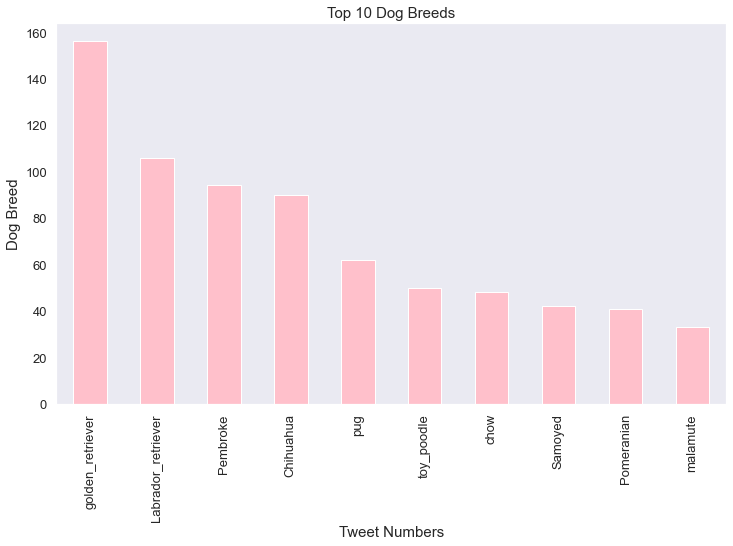

In [139]:
#Let' s plot the breeds in here
fig = plt.figure(figsize=(12,7))
bar_data.plot(kind='bar',color='pink')
plt.title("Top 10 Dog Breeds",fontsize=15)
plt.xlabel("Tweet Numbers",fontsize=15)
plt.ylabel("Dog Breed",fontsize=15)
plt.xticks(rotation=90);
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(None)
plt.show()

* We can easily see that the most tweeted dog is Golden Retriever. And the big 3 is the Golden Retriever, Labrador Retriever
Pembroke

2) Dog Breeds With Highest Ratings

In [140]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1895,667405339315146752,2015-11-19 18:13:27,Twitter for iPhone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden
1894,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1893,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,None,0.000000,None


In [141]:
breed_counts=df_all['breed_name'].value_counts() #dog breeds with more than 10 counts. 
breed_counts

golden_retriever        156
Labrador_retriever      106
Pembroke                 94
Chihuahua                90
pug                      62
                       ... 
Irish_wolfhound           1
Scotch_terrier            1
Bouvier_des_Flandres      1
silky_terrier             1
clumber                   1
Name: breed_name, Length: 113, dtype: int64

In [142]:
df_breed_counts = df_all[df_all['breed_name'].isin(breed_counts[breed_counts > 10].index)] #selecting the >10 counts breeds in here. 
df_breed_counts.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1894,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1891,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,284.0,75.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,None,Labrador_retriever,0.825670,Cupcake
1889,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,https://twitter.com/dog_rates/status/667470559035432960/photo/1,11,10,227.0,85.0,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,None,toy_poodle,0.304175,None


In [143]:
df_breed_counts=df_breed_counts[df_breed_counts['rating_numerator']<=14] #Extracting the outliers in here. 

In [144]:
df_breed_counts.groupby('breed_name')['rating_numerator'].mean().sort_values(ascending=False).nlargest(10) #Listing the top 10 breeds. 

breed_name
Samoyed                 11.690476
golden_retriever        11.571429
Great_Pyrenees          11.428571
Pembroke                11.425532
Eskimo_dog              11.409091
chow                    11.404255
cocker_spaniel          11.333333
kelpie                  11.307692
Siberian_husky          11.300000
Bernese_mountain_dog    11.272727
Name: rating_numerator, dtype: float64

In [145]:
data_h_2=df_breed_counts.groupby('breed_name')['rating_numerator'].mean().sort_values(ascending=False).nlargest(10)
data_h_2.head(3)

breed_name
Samoyed             11.690476
golden_retriever    11.571429
Great_Pyrenees      11.428571
Name: rating_numerator, dtype: float64

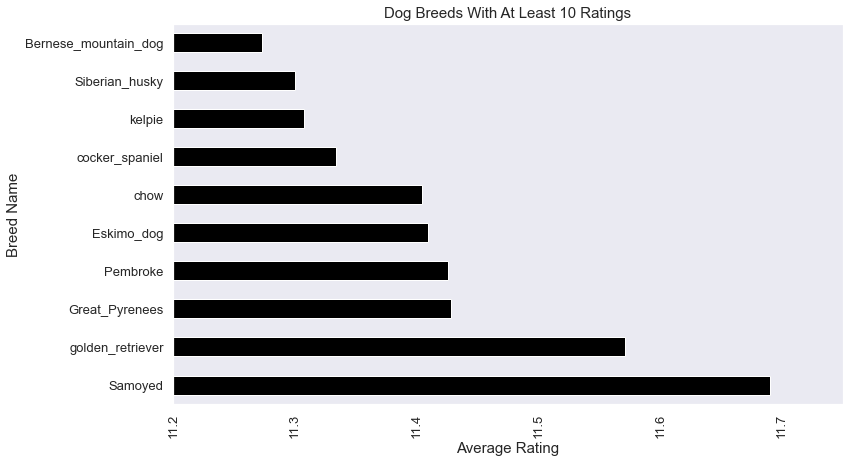

In [146]:
#Plotting the top 10 dog breeds
fig = plt.figure(figsize=(12,7))
data_h_2.plot(kind='barh',color='black')
plt.title("Dog Breeds With At Least 10 Ratings",fontsize=15)
plt.xlabel("Average Rating",fontsize=15)
plt.ylabel("Breed Name",fontsize=15)
plt.xticks(rotation=90);
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(None)
plt.xlim(11.2,11.75)
plt.show()

* We see in this chart that our top 5 performer breeds are Samoyed, Golden_Retriever, Great-Pyrenees, Pembroke and Eskimo_Dog. 

3) Dog Breeds With Most Likes

In [147]:
df_breed_counts.head(3) #Our last dataframe

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names
1894,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None
1891,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11,10,284.0,75.0,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,None,Labrador_retriever,0.825670,Cupcake
1889,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,https://twitter.com/dog_rates/status/667470559035432960/photo/1,11,10,227.0,85.0,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,None,toy_poodle,0.304175,None


In [148]:
#We need to check the 'favorites' column to see the likes per group of the breeds in here. 

df_breed_counts.groupby('breed_name')['favorites'].sum().head()

breed_name
Airedale                           54758.0
American_Staffordshire_terrier    109557.0
Bernese_mountain_dog               69740.0
Border_collie                      93311.0
Boston_bull                        54866.0
Name: favorites, dtype: float64

In [149]:
df_breed_counts.groupby('breed_name')['favorites'].count().head() # Number of tweets per dog breed

breed_name
Airedale                          12
American_Staffordshire_terrier    15
Bernese_mountain_dog              11
Border_collie                     12
Boston_bull                       12
Name: favorites, dtype: int64

In [150]:
# Average number of likes 
df_avg_num_likes=(df_breed_counts.groupby('breed_name')['favorites'].sum()/df_breed_counts.groupby('breed_name')['favorites'].count())
df_avg_num_likes.head()

breed_name
Airedale                          4563.166667
American_Staffordshire_terrier    7303.800000
Bernese_mountain_dog              6340.000000
Border_collie                     7775.916667
Boston_bull                       4572.166667
Name: favorites, dtype: float64

In [151]:
# Creating the data for plotting

data_h_3=df_avg_num_likes.sort_values(ascending=False).nlargest(10)
data_h_3.head()

breed_name
French_bulldog     17798.533333
whippet            12775.000000
standard_poodle    12141.454545
Samoyed            11931.829268
cocker_spaniel     11924.900000
Name: favorites, dtype: float64

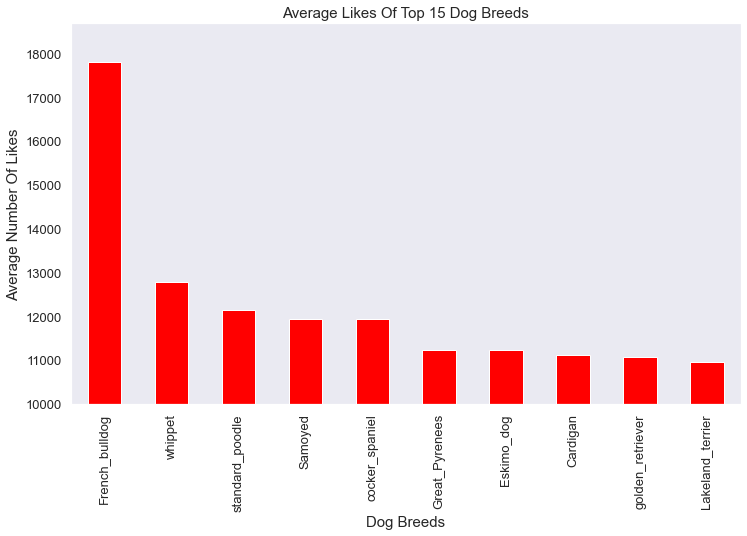

In [355]:
#Plotting the average most likes of the top 15 dog breeds

fig = plt.figure(figsize=(12,7))
data_h_3.plot(kind='bar',color='red')
plt.title("Average Likes Of Top 15 Dog Breeds",fontsize=15)
plt.ylabel("Average Number Of Likes",fontsize=15)
plt.xlabel("Dog Breeds",fontsize=15)
plt.xticks(rotation=90);
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid(None)
plt.ylim(10000,)
plt.show()

* In here we can see that the first one is French Bulldog, second Whippet, third Standard Poodle and so on. When we compare
this chart with our other charts we can see that Golden Retriever, Samoyed and French Bulldog are seen predominantly in the 
graphs.


* In graph 1 top 3 dogs are Golden Retriever, Labrador Retriever and Pembroke. In graph 2 Samoyed, Golden_Retriever and Great-Pyrenees. In graph 3 French Bulldog, Whippet and Standard Poodle.

4) The Most Tweets of The Dog Breeds By Time  

In [178]:
df_all.timestamp=pd.to_datetime(df_all.timestamp)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 1895 to 6618
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   category      
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   favorites           1961 non-null   float64       
 8   retweet_count       1961 non-null   float64       
 9   jpg_url             1971 non-null   object        
 10  dog_type            1971 non-null   category      
 11  breed_name          1666 non-null   object        
 12  confidence_rate     1971 non-null   float64       
 13  dog_names           1971 non-null   object   

In [207]:
tweet_hour=df_all.timestamp.dt.hour
tweet_hour

1895    18
1894    20
1893    20
1892    20
1891    21
        ..
6046     3
6390    16
6588    23
6443     0
6618    19
Name: timestamp, Length: 1971, dtype: int64

In [272]:
df_all['tweet_hour']=tweet_hour

In [273]:
df_all.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,favorites,retweet_count,jpg_url,dog_type,breed_name,confidence_rate,dog_names,tweet_hour
1895,667405339315146752,2015-11-19 18:13:27,Twitter for iPhone,This is Biden. Biden just tripped... 7/10 https://t.co/3Fm9PwLju1,https://twitter.com/dog_rates/status/667405339315146752/photo/1,7,10,422.0,199.0,https://pbs.twimg.com/media/CUMZnmhUEAEbtis.jpg,None,Saint_Bernard,0.381377,Biden,18
1894,667435689202614272,2015-11-19 20:14:03,Twitter for iPhone,Ermergerd 12/10 https://t.co/PQni2sjPsm,https://twitter.com/dog_rates/status/667435689202614272/photo/1,12,10,274.0,78.0,https://pbs.twimg.com/media/CUM1OHCW4AEgGSi.jpg,None,Rottweiler,0.999091,None,20
1893,667437278097252352,2015-11-19 20:20:22,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,405.0,208.0,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,None,0.000000,None,20


In [274]:
df_hours=df_all.groupby(['tweet_hour']).sum()['retweet_count']
df_hours

tweet_hour
0     794908.0
1     565767.0
2     328582.0
3     194870.0
4      98361.0
5      36969.0
6      54668.0
13       327.0
14      9538.0
15    235138.0
16    581683.0
17    342135.0
18    344078.0
19    195372.0
20    163683.0
21    145706.0
22    139848.0
23    270849.0
Name: retweet_count, dtype: float64

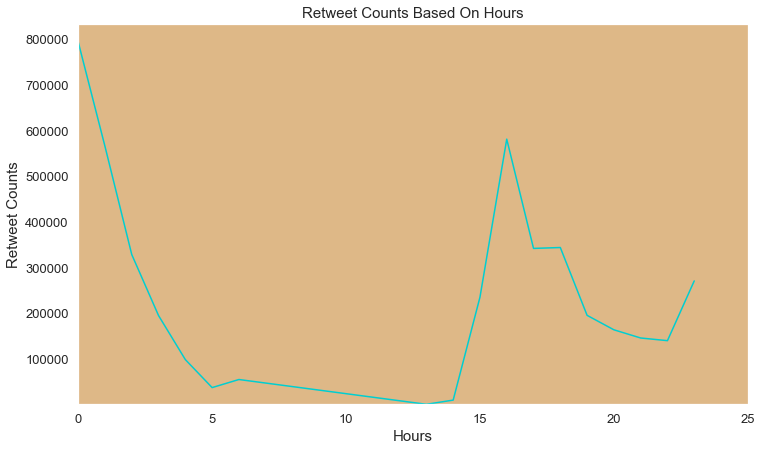

In [377]:
fig,ax==plt.figure(figsize=(12,7))
ax=plt.axes()
ax.set_facecolor("burlywood")
df_hours.plot(kind='line',color='darkturquoise')
plt.title("Retweet Counts Based On Hours",fontsize=15)
plt.ylabel("Retweet Counts",fontsize=15)
plt.xlabel("Hours",fontsize=15)
plt.xticks(rotation=0);
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(df_hours.values.min(),)
plt.xlim(df_hours.index.min(),25)
plt.grid(None)
plt.show()

* In this chart we can easily see that around 00:00 it is the time for the heighest retweet counts. And between 10:00 and 15:00 it is the lowest for the retweet counts.


* Companies may use this data for their advertisements. For example in these time periods they may think that the people are much busier or less busier so with that they may adjust the correct time use for their advertisements based on these limited times. Maybe they may offer more advertisements of the dog breeds (food, shelter, some kinds of dog needs or their owner needs etc.) around midnight (00:00) and then they may offer more again later between 15:00 and 17:00 too.

To sum up, according to the first 3 graphs we conclude that Samoyed, Golden Retriever and French Bulldog are the most popular dogs. 

Therefore we may analyze deeply about these dogs including some topics like their favorite foods, the places they are most frequented etc. about them later on. Including their popularity based on the regions, the best places for them to live long and healty, their relationships with the other dog breeds or maybe we may take some detailed researches into account about their relationships with their owners too.

Plus, in our analyses we may make more inferences based on the time. And companies can use this the time based data in their researches, advertisements or another kind of work for example future engineering or some statistical issues as well. 